# Compute the log determinant and derivatives using Chebyshev expansion

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Setting up the problem

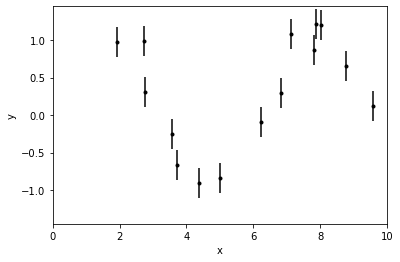

In [2]:
import george
from george import kernels
import numpy as np
import matplotlib.pyplot as pl


np.random.seed(1234)
x = 10 * np.sort(np.random.rand(15))
yerr = 0.2 * np.ones_like(x)
y = np.sin(x) + yerr * np.random.randn(len(x))

pl.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
pl.xlim(0, 10)
pl.ylim(-1.45, 1.45)
pl.xlabel("x")
pl.ylabel("y");

The fun part is here, choosing a particular model for the Kernel:

In [23]:
kernel = np.var(y)*kernels.ExpSquaredKernel(0.2)

gp = george.GP(kernel)
gp.compute(x, yerr)

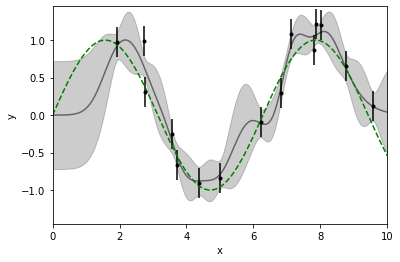

In [4]:
x_pred = np.linspace(0, 10, 500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

pl.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
pl.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
pl.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
pl.plot(x_pred, np.sin(x_pred), "--g")
pl.xlim(0, 10)
pl.ylim(-1.45, 1.45)
pl.xlabel("x")
pl.ylabel("y");

## Computing the gradients stochastically

In [7]:
import sys
sys.path.insert(0,'..')

In [8]:
from sssob.chebyshev import chebyshev_logdet

In [24]:
# Step I: We extract the Kernel and it's derivatives from the kernel object
# to define Matrix- vector-product operations
M = kernel.get_value(atleast_2d(x).T) 
def mvp(x):
    return M.dot(x)

Mg = kernel.get_gradient(atleast_2d(x).T)
def gmvp(x):
    return np.einsum('ijk,jk->ik', Mg, x)

In [25]:
# Step II: Compute the log det and its derivatives using the Chebyshev expansion 
log_det, glog_det = chebyshev_logdet(mvp, gmvp, shape=(15,1), m=1000, deg=100, g=1.5, eps=1e-15)

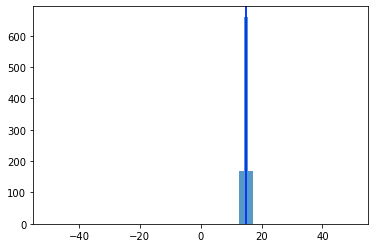

In [29]:
hist(glog_det[:,0],64,alpha=0.75, range=[-50,50]);
axvline(mean(glog_det[:,0]),color='cyan', label="est grad theta1");
axvline(trace(pinv(M).dot(Mg[:,:,0])),color='blue', label="true grad theta1");

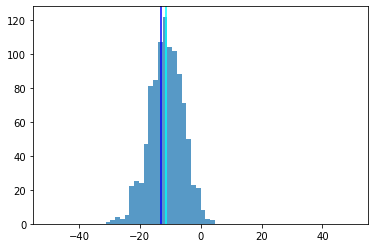

In [30]:
hist(glog_det[:,1],64,alpha=0.75, range=[-50,50]);
axvline(mean(glog_det[:,1]),color='cyan', label="est grad theta1");
axvline(trace(pinv(M).dot(Mg[:,:,1])),color='blue', label="true grad theta1");